In [11]:
import cv2
import os 
import matplotlib.pyplot as plt
import numpy as np 
from random import shuffle 
from tqdm import tqdm 
import pandas as pd
LR = 1e-3
IMG_SIZE = 100

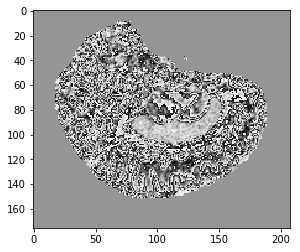

In [12]:
headdata = np.fromfile("F:\\masked_gfc_imgs\\OAS1_0001_MR1_mpr_n4_anon_111_t88_masked_gfc.img", dtype=np.int16)
hdata = headdata.reshape(176,208,176 )
plt.imshow(hdata[:,:,100],cmap="Greys")

In [13]:
slice_0 = hdata[88, :, :]
slice_1 = hdata[:, 104, :]
slice_2 = hdata[:, :, 88]

In [14]:
def show_slices(slices):
    fig, axes = plt.subplots(1, len(slices))
    for i, slice in enumerate(slices):
        axes[i].imshow(slice.T, cmap="gray", origin="lower")

Text(0.5, 0.98, 'Center slices for MRI image')

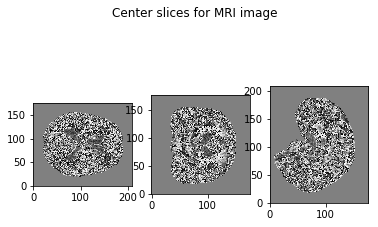

In [15]:
show_slices([slice_0, slice_1, slice_2])
plt.suptitle("Center slices for MRI image")

In [16]:
labels_df = pd.read_csv('C://Users//lvyue//Desktop//ML/oasis_cross-sectional.csv')
labels_df = labels_df.drop(columns=['M/F','Hand','Age','Educ','SES','MMSE','eTIV','nWBV','ASF','Delay'])
labels_df = labels_df.fillna(0)
labels_df.head()

,ID,CDR
0,OAS1_0001_MR1,0.0
1,OAS1_0002_MR1,0.0
2,OAS1_0003_MR1,0.5
3,OAS1_0004_MR1,0.0
4,OAS1_0005_MR1,0.0


In [17]:
'''Setting up the model which will help with tensorflow models'''
MODEL_NAME = 'Alzheimer-{}-{}.model'.format(LR, '6conv-basic') 
  
'''Labelling the dataset'''
def label_img(img):
    names = img.split('_mpr')[0]
    for i in range(0,436):
        if list(labels_df['ID'])[i]== names:
            labels = list(labels_df['CDR'])[i]
            #print("index is", i,"CDR is",label)
            
    
    
    # DIY One hot encoder 
    if labels == 0.0: return [1, 0, 0, 0 ] 
    elif labels == 0.5: return [0, 1, 0, 0 ]
    elif labels ==1.0: return [0, 0, 1, 0 ]
    elif labels ==2.0: return [0, 0, 0, 1 ]

    

In [18]:
TRAIN_DIR = 'F:\\masked_gfc_imgs'

In [19]:
'''Creating the training data'''
def create_train_data(): 
    # Creating an empty list where we should the store the training data 
    # after a little preprocessing of the data 
    training_data = [] 
    for img in tqdm(os.listdir(TRAIN_DIR)):
        path = os.path.join(TRAIN_DIR, img)
        imgs = np.fromfile(path, dtype=np.int16)
        if len(imgs)==6443008:
            label = label_img(img)
            imgs = imgs.reshape(176,208,176)
            imgs = imgs[:,:,100]
            imgs = cv2.resize(imgs, (IMG_SIZE,IMG_SIZE))
        # final step-forming the training data list with numpy array of the images 
        training_data.append([np.array(imgs), np.array(label)]) 
  
    # shuffling of the training data to preserve the random state of our data 
    shuffle(training_data) 
  
    # saving our trained data for further uses if required 
    np.save('train_data.npy', training_data) 
    return training_data 
  

In [20]:
'''Processing the given test data'''
# Almost same as processing the traning data but 
# we dont have to label it. 
def process_test_data(): 
    testing_data = [] 
    for img in tqdm(os.listdir(TRAIN_DIR)):
        path = os.path.join(TRAIN_DIR, img)
        imgs = np.fromfile(path, dtype=np.int16)
        if len(imgs)==6443008:
            label = label_img(img)
            imgs = imgs.reshape(176,208,176)
            imgs = imgs[:,:,100]
            imgs = cv2.resize(imgs, (10,10))
            
        testing_data.append(np.array(imgs))  
    shuffle(testing_data) 
    np.save('test_data.npy', testing_data) 
    return testing_data 
  

In [21]:
'''Running the training and the testing in the dataset for our model'''
train_data = create_train_data() 
test_data = process_test_data() 
  
#train_data = np.load('train_data.npy') 
#test_data = np.load('test_data.npy') 
'''Creating the neural network using tensorflow'''
# Importing the required libraries 
import tflearn 
from tflearn.layers.conv import conv_2d, max_pool_2d 
from tflearn.layers.core import input_data, dropout, fully_connected 
from tflearn.layers.estimator import regression 

import tensorflow as tf 
tf.reset_default_graph() 
convnet = input_data(shape =[None, IMG_SIZE,IMG_SIZE, 1], name ='input') 
  
convnet = conv_2d(convnet, 32, 5, activation ='relu') 
convnet = max_pool_2d(convnet, 5) 
  
convnet = conv_2d(convnet, 64, 5, activation ='relu') 
convnet = max_pool_2d(convnet, 5) 
  
convnet = conv_2d(convnet, 128, 5, activation ='relu') 
convnet = max_pool_2d(convnet, 5) 
  
convnet = conv_2d(convnet, 64, 5, activation ='relu') 
convnet = max_pool_2d(convnet, 5) 
  
convnet = conv_2d(convnet, 32, 5, activation ='relu') 
convnet = max_pool_2d(convnet, 5) 
  
convnet = fully_connected(convnet, 1024, activation ='relu') 
convnet = dropout(convnet, 0.8) 
  
convnet = fully_connected(convnet, 2, activation ='softmax') 
convnet = regression(convnet, optimizer ='adam', learning_rate = LR, loss ='categorical_crossentropy', name ='targets') 
  
model = tflearn.DNN(convnet, tensorboard_dir ='log') 
  

100%|████████████████████████████████████████████████████████████████████████████████| 437/437 [02:30<00:00,  2.90it/s]


In [22]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
K.set_image_dim_ordering('th')

In [24]:
def conv3d(x, W):
    return tf.nn.conv3d(x, W, strides=[1,1,1,1,1], padding='SAME')

def maxpool3d(x):
    #                        size of window         movement of window as you slide about
    return tf.nn.max_pool3d(x, ksize=[1,2,2,2,1], strides=[1,2,2,2,1], padding='SAME')


In [25]:
SLICE_COUNT = 20

n_classes = 2
batch_size = 10

x = tf.placeholder('float')
y = tf.placeholder('float')

keep_rate = 0.8

In [26]:
def convolutional_neural_network(x):
    #                # 5 x 5 x 5 patches, 1 channel, 32 features to compute.
    weights = {'W_conv1':tf.Variable(tf.random_normal([3,3,3,1,32])),
               #       5 x 5 x 5 patches, 32 channels, 64 features to compute.
               'W_conv2':tf.Variable(tf.random_normal([3,3,3,32,64])),
               #                                  64 features
               'W_fc':tf.Variable(tf.random_normal([54080,1024])),
               'out':tf.Variable(tf.random_normal([1024, n_classes]))}

    biases = {'b_conv1':tf.Variable(tf.random_normal([32])),
               'b_conv2':tf.Variable(tf.random_normal([64])),
               'b_fc':tf.Variable(tf.random_normal([1024])),
               'out':tf.Variable(tf.random_normal([n_classes]))}

    #                            image X      image Y        image Z
    x = tf.reshape(x, shape=[-1, IMG_SIZE, IMG_SIZE, SLICE_COUNT, 1])

    conv1 = tf.nn.relu(conv3d(x, weights['W_conv1']) + biases['b_conv1'])
    conv1 = maxpool3d(conv1)


    conv2 = tf.nn.relu(conv3d(conv1, weights['W_conv2']) + biases['b_conv2'])
    conv2 = maxpool3d(conv2)

    fc = tf.reshape(conv2,[-1, 54080])
    fc = tf.nn.relu(tf.matmul(fc, weights['W_fc'])+biases['b_fc'])
    fc = tf.nn.dropout(fc, keep_rate)

    output = tf.matmul(fc, weights['out'])+biases['out']

    return output

In [27]:
much_data = np.load('train_data.npy')
# If you are working with the basic sample data, use maybe 2 instead of 100 here... you don't have enough data to really do this
train_data = much_data[:-100]
validation_data = much_data[-100:]


def train_neural_network(x):
    prediction = convolutional_neural_network(x)
    cost = tf.reduce_mean( tf.nn.softmax_cross_entropy_with_logits(prediction,y) )
    optimizer = tf.train.AdamOptimizer(learning_rate=1e-3).minimize(cost)
    
    hm_epochs = 10
    with tf.Session() as sess:
        sess.run(tf.initialize_all_variables())
        
        successful_runs = 0
        total_runs = 0
        
        for epoch in range(hm_epochs):
            epoch_loss = 0
            for data in train_data:
                total_runs += 1
                try:
                    X = data[0]
                    Y = data[1]
                    _, c = sess.run([optimizer, cost], feed_dict={x: X, y: Y})
                    epoch_loss += c
                    successful_runs += 1
                except Exception as e:
                    # I am passing for the sake of notebook space, but we are getting 1 shaping issue from one 
                    # input tensor. Not sure why, will have to look into it. Guessing it's
                    # one of the depths that doesn't come to 20.
                    pass
                    #print(str(e))
            
            print('Epoch', epoch+1, 'completed out of',hm_epochs,'loss:',epoch_loss)

            correct = tf.equal(tf.argmax(prediction, 1), tf.argmax(y, 1))
            accuracy = tf.reduce_mean(tf.cast(correct, 'float'))

            print('Accuracy:',accuracy.eval({x:[i[0] for i in validation_data], y:[i[1] for i in validation_data]}))
            
        print('Done. Finishing accuracy:')
        print('Accuracy:',accuracy.eval({x:[i[0] for i in validation_data], y:[i[1] for i in validation_data]}))
        
        print('fitment percent:',successful_runs/total_runs)

# Run this locally:
# train_neural_network(x)